In [1]:
import pandas as pd
import numpy as np 
import statsmodels.api as sm
from statsmodels.tsa.arima_process import arma_generate_sample
import matplotlib.pyplot as plt 

%matplotlib inline
from scipy import stats
from statsmodels.graphics.api import qqplot

from statsmodels.tsa.stattools import adfuller

# Introducción

Los modelos de tendencia determinista y la caminata aleatoria con drift tienen valores esperado que crece linealmente con el tiempo, pero difieren en la fuente de su no estacionariedad. Uno tiene una tendencia deterministica y el otro una tendencia determinista. Conocer la fuente de la no estacionariedad tiene implicaciones políticas en el mundo real. Por ejemplo, 

1. Si el PIB del Ecuador tien tendencia determinista, cualquier shock se amortiguará con el tiempo y se volverá irrelevante. Si fuera un proceso de caminata aleatoria, unca superar'a el shock. Por lo tanto, los efectos de una mala política económica hace décadas,  todavía se sentiría hoy. 

3. Si el precio de las acciones de una empresa siguen una tendencia estocástico, los shocks temporales (mala gestión por parte del CEO, una crisis energética inesperada, una pequeña recesión) afectarán el precio de las acciones indefinidamente en el futuro. Si el precio de la acción se determina mediante un modelo de tendencia determinista, la acción se recuperará.

# ¿Qué es una raíz unitaria?


Considere el procese AR(1):

$y_t = \beta_1 y_{t-1}+ e_t$

Donde $e_t$ es un ruido blanco. En generala hay tres casos:

1. Si $|\beta_1|<1$, el proceso es estacionario.
2. Si $|\beta_1|>1$, la series explota
3. Si $\beta_1 =1$ la serie tiene una raiz unitaria y no es estacionaria.


In [2]:
# Ejemplo de los tres casos

n =100

y = np.zeros(n) 
x = np.zeros(n) 
z = np.zeros(n) 
w = np.zeros(n) 


for i in range(0,n):
    
    e = np.random.normal(0, 2, 1)
    u = np.random.normal(0, 1, 1)
    
    w[i] = 0.67*w[i - 1] + e
    
    x[i] = 1.26*x[i - 1] + e
    
    z[i] = z[i - 1] + e
    
    y[i] = y[i - 1] + u

y = pd.Series(y)    
x = pd.Series(x)  
w = pd.Series(w)
z = pd.Series(z)

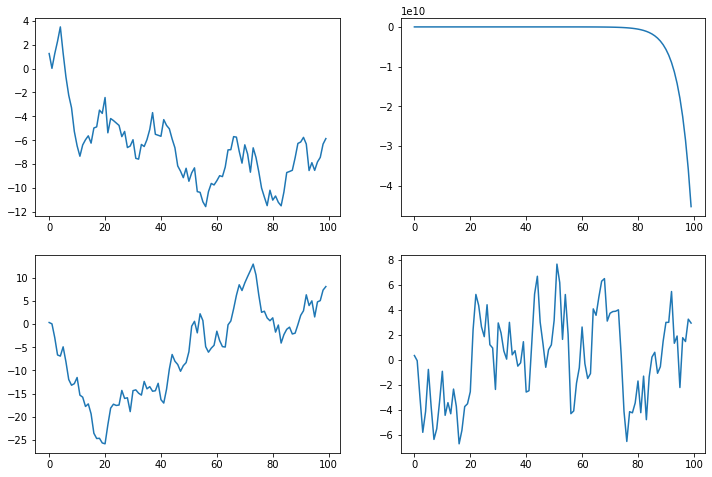

In [3]:
figure,axes = plt.subplots(2,2,figsize=(12,8))

y.plot(ax=axes[0,0])
z.plot(ax=axes[1,0])
x.plot(ax=axes[0,1])
w.plot(ax=axes[1,1])

# Regresion espuria

Considere la ecuacion de regresion

$y_t = a_0 + a_1 z_t +e_t$

Donde $e_t$ es un termino de error que pudiera estar autocorrelacionado.  Asuma que,

$y_t =  y_{t-1} +u_{yt}$ 

$z_t =  z_{t-1} +u_{zt}$

Para que los supuesto del MCO sean aplicables, se requiere que ambas series sean estacionaria, y los errores tengan media cero y varianza finita. Sin  embargo, cuando las series son no estacionaria, estamos en presencia de una regresion espuria (Granger y Newbold, 1974).

Una regresion espuria tiene un $R^2$ y t estadistico que parace ser significativos, pero no tiene ningun significado economico. A partir de esto se debe tener cuidado al trabajar con series no estacionarias. Hya 4 casos posibles:

1. Ambas series $y_t$ y $z_t$ son estacionarias. En este caso los metodos de regresion clasico son validos
2. Ambas series $y_t$ y $z_t$ son integradas en diferentes ordenes. En este caso los resultados de la regresion no tienen ningun significado.
3.  Ambas series $y_t$ y $z_t$ son integradas del mismo orden y los residuos tienen una tendencia estocasticas. Es este caso la regresion es espuria. Se recomienda estimar el modelo con las variable sen primera diferencia: $\Delta y_t = a_1 \Delta z_t +\Delta e_t$
4. Las series no son estacionarias pero los errores son estacionarios. En esta circunstancia las series conintegran.

La forma más simple de examinar las propiedades de la secuencia $e_t$ es abstraer del término de intercepción $a_0$ y reescribir como

$e_t = y_t - a_1z_t$

Si $y_t$ y $z_t$ son caminatas aleatorias podemos imponer las condiciones iniciales $y_0 = z_0 = 0$ para que

$e_t =\sum^t{u_{yi}}-a_1 \sum^t{u_{zi}}$

Claramente, la varianza del error se vuelve infinitamente grande a medida que aumenta t. Además, el error tiene un componente permanente$E_te_{t + i} = e_t$ para todo $i \geq 0$. Por lo tanto, los supuestos para realizar las pruebas de hipótesis habituales se violan de modo que cualquier prueba t, prueba F o Los valores de $R^2$ no son confiables. Es fácil ver que los residuos estimados de la regresion espuria exhibirán un alto grado de autocorrelación. 

Aunque el verdadero valor de $a_1 = 0$, suponga que estima y desea para probar la hipótesis nula $a_1 = 0$. De debe quedar claro que el término de error es no estacionario. Ademas, la suposición de que el término de error tiene una raíz unitaria es inconsistente con la teoría distributiva subyacente al uso de OLS. Este problema no desaparece en grandes muestras. De hecho, Phillips (1986) demuestra que cuanto mayor es la muestra, es más probable que concluyas falsamente que $a_1 \neq 0$


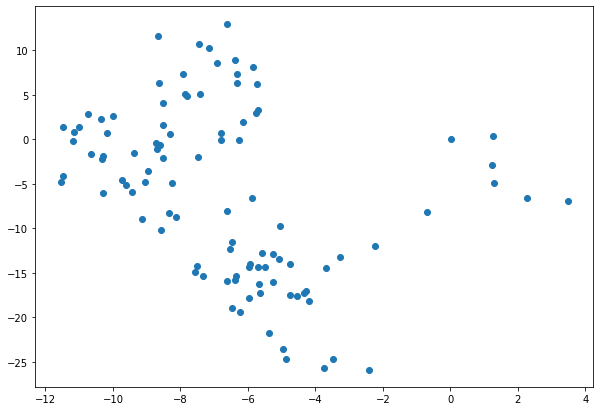

In [4]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot( y,z, 'o', label="data")

In [5]:
# Estimando una regresion espuria

X=sm.add_constant(z)
model = sm.OLS(y,X)
results = model.fit()
print(results.summary(xname=['const','z']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     12.66
Date:                Wed, 01 Jul 2020   Prob (F-statistic):           0.000577
Time:                        22:31:37   Log-Likelihood:                -247.23
No. Observations:                 100   AIC:                             498.5
Df Residuals:                      98   BIC:                             503.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.2506      0.343    -21.134      0.0

In [6]:
residual=results.resid
yhat = results.fittedvalues

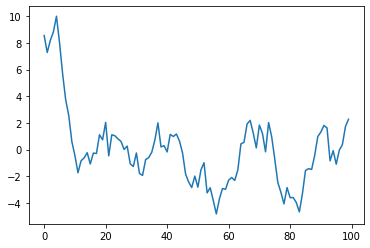

In [7]:
residual.plot()

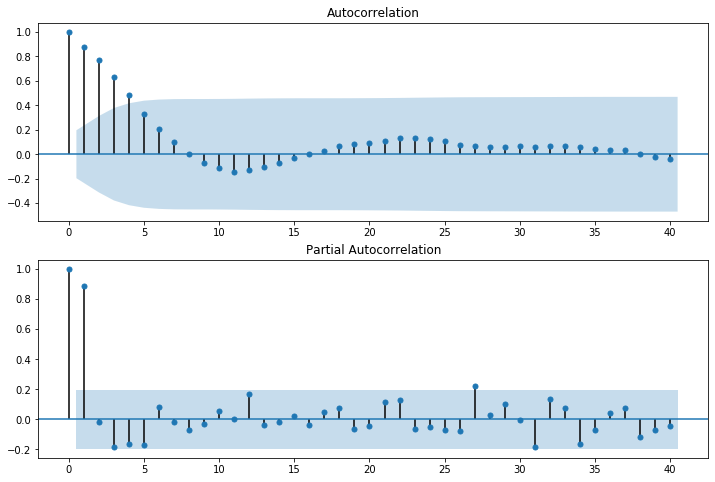

In [8]:
fig = plt.figure(figsize=(12,8))

#Plot ACF
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residual, lags=40, ax=ax1)

#Plot PACF
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residual, lags=40, ax=ax2)

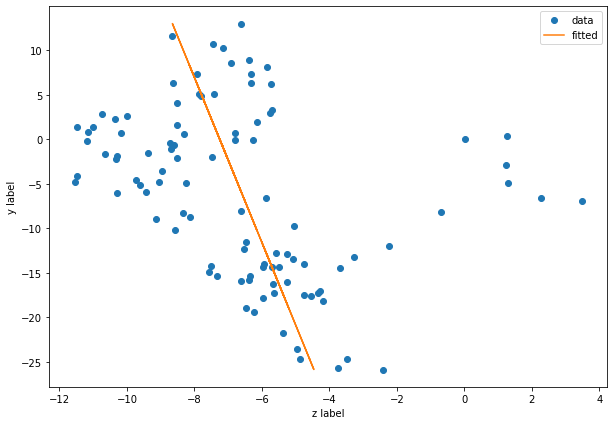

In [9]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot( y,z, 'o', label="data")
ax.plot( yhat,z, '-', label="fitted")
ax.set_xlabel("z label")
ax.set_ylabel("y label")
ax.legend()

1. Como las series $y_t$ y $z_t$ son independientes el uno del otro, la regresion no tiene sentido.

2. Sorprendentemente, al nivel de significancia del 5%, se rechaza la hipótesis nula $\beta_1 = 0$.

3. El de $R^2$ es alto.

4. Los residuos estimados exhiben un alto grado de autocorrelación. La regresión no tiene  sentido si los residuos no son estacionaria. Cualquier error en el período t nunca decae para que cualquier desviación del modelo sea permanente. 


# Dickey-Fuller Tests

Es importante poder identificar si los datos provienen de un proceso con tendencia determinista o estocastica, y la mejor manera de estimar dicha tendencia. 

## Evitar errores

1. No se debe diferenciar o detrending una serie estacionaria. 
2. No se debe detrending una serie que tiene un proceso de raíz unitaria.
3. No se debe diferenciar un proceso estacionario de tendencia. 

Aunque las propiedades de las ACF y PACF son herramientas útiles para detectar la posible presencia de raíces unitarias o tendencias deterministas, el método es necesariamente impreciso. Lo que puede aparecer como una raíz unitaria para una personas puede aparecer como un proceso estacionario para otro. 

El problema es difícil porque un proceso con una raíz cercana a la unidad tendrá el mismo ACF como el de un proceso que contiene una tendencia. Por ejemplo, el ACF de un proceso estacionario AR(1) con $\beta_1 = 0.95$ exhibirá un desvanecimiento gradual indicativo de un proceso no estacionario. 

Para ilustrar algunos de los problemas involucrados, suponga que sabemos que se genera una serie a partir del siguiente proceso de primer orden:

$y_t = \beta_1  y_{t-1} + e_t$

donde $e_t$ es ruido blanco. Primero, supongamos que deseamos probar la hipótesis nula de que $\beta_1  = 0$. Bajo dicha 
hipótesis, podemos estimar el modelo usando MCO. El hecho de que es  un proceso de ruido blanco y que $|\beta_1 |<1$ garantiza que la serie $y_t$ es estacionaria y que la estimación de $\beta_1$ es eficiente. Usted puede usar una prueba t para determinar si $\beta_1$  es significativamente diferente desde cero,

La situación es bastante diferente si queremos probar la hipótesis $\beta_1  = 1$. Ahora, bajo la hipótesis nula, la serie $y_t$ es generada por el proceso no estacionario que puede ser expresado comoÑ

$y_t = y_0 + \sum_{i=1}^t{e_i}$

Por lo tanto, si $\beta_1  = 1$, la varianza se vuelve infinitamente grande a medida que t aumenta. Bajo la hipótesis nula, es inapropiado usar métodos estadísticos clásicos para estimar y realizar pruebas de significación sobre $\beta_1$. La estimación  MCO  producirá una estimación sesgada de $\beta_1$. Podemos demostrar que el coeficiente de autocorrelación de primer orden está sesgado para estar por debajo de su verdadero valor (que es 1). La prueba t habitual no puede ser usado para probar la hipótesis $\beta_1  = 1$.

## Procedimiento de Dickey y Fuller (1979)

Para determinar si $\beta_1  = 1$ se comienza restando $y_{t-1}$ de cada lado de la ecuación en orden
para escribir la forma equivalente: $\Delta y_t = \gamma y_{t-1} + e_t$ donde $\gamma = \beta_1 - 1$. Por supuesto, prueba
la hipótesis $\beta_1  = 1$ es equivalente a probar la hipótesis $\gamma = 0$. Dickey y Fuller (1979) consideran tres ecuaciones de regresión diferentes que pueden usarse para evaluar la presencia de una raíz unitaria:

$\Delta y_t = \gamma y_{t − 1}+ e_t$

$\Delta y_t  = a_0 + \gamma y_{t − 1}  + e_t$

$\Delta y_t  = a_0 + \gamma y_{t − 1} + a_2t + e_t$

La diferencia entre las tres regresiones es la presencia de los elementos $a_0$ y $a_2t$. El primero es un modelo de caminata aleatoria, el segundo agrega un drift, y el tercero incluye tanto un drift y una tendencia deterministica lineal.

El parámetro de interés en todas las ecuaciones de regresión es $\gamma $; si $\gamma  = 0$, la secuencia $y_t$ contiene una raíz unitaria. La prueba implica estimar uno (o más) de las ecuaciones anteriores usando MCO para obtener el valor de estimado de $\gamma$  y el error estándar asociado. Se compara el estadístico t resultante con el apropiado valor reportado en las tablas Dickey-Fuller ([1](#Notas)), y asi podemos evaluar si se rechaza o no la hipótesis nula $\gamma  = 0$.


<img src="fig8.png" align="center"  width="300" height="350">




In [90]:
def adf_test(timeseries,exog):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, maxlag=5,regression=exog,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# Ejemplo 1

In [100]:
n =100

y = np.zeros(n) 
x = np.zeros(n) 
z = np.zeros(n) 
trend = np.zeros(n)

for i in range(0,n):
    
    e = np.random.normal(0, 2, 1)
    u = np.random.normal(0, 1, 1)
    v = np.random.normal(0, 1, 1)
    
    y[i] = 1.5 + y[i - 1] + e
    
    x[i] = 0.5 + 0.75*i + u
    
    z[i] = 1 + i + v
    
    trend[i]=i

    
# y = pd.Series(y)
frame = { 't': trend, 'y': y } 
dfy = pd.DataFrame(frame)
dfy.index = pd.period_range('2002-01-01', '2010-04-01', freq='M')

dfy['ly']=dfy['y'].shift()
dfy['dy']=dfy['y'].diff()
dfy['dly']=dfy['dy'].shift()
dfy=dfy[1:]


frame = { 't': trend, 'x': x } 
dfx = pd.DataFrame(frame)
dfx.index = pd.period_range('2002-01-01', '2010-04-01', freq='M')
dfx['lx']=dfx['x'].shift()
dfx['dx']=dfx['x'].diff()
dfx['dlx']=dfx['dx'].shift()
dfx=dfx[1:]


## Paso 1: plot y

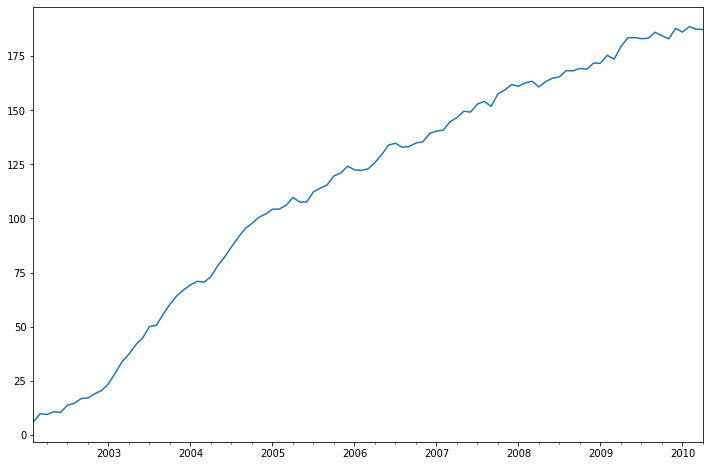

In [101]:
dfy['y'].plot(figsize=(12,8))

In [199]:
dfy.head()

,t,y,ly,dy,dly
2002-02,1.0,5.899066,1.797440,4.101626,NaN
2002-03,2.0,9.747394,5.899066,3.848328,4.101626
2002-04,3.0,9.385810,9.747394,-0.361583,3.848328
2002-05,4.0,10.653524,9.385810,1.267714,-0.361583
2002-06,5.0,10.329343,10.653524,-0.324181,1.267714


## Paso 2: correr el test



In [102]:
adf_test(dfy['y'],'ct')

Results of Dickey-Fuller Test:
Test Statistic                 -0.321422
p-value                         0.989010
#Lags Used                      0.000000
Number of Observations Used    98.000000
Critical Value (1%)            -4.054251
Critical Value (5%)            -3.456279
Critical Value (10%)           -3.153866
dtype: float64


## Paso 3: estimamos la regresion

$\Delta y_t  = a_0 + \gamma y_{t − 1} + a_2t + e_t$

In [103]:
X = [dfy['t'],dfy['ly']]
X= np.column_stack(X)
X=sm.add_constant(X)

model = sm.OLS(dfy['dy'],X)
results = model.fit()

print(results.summary(xname=['const','trend','ly']))
# print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     dy   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     5.671
Date:                Thu, 02 Jul 2020   Prob (F-statistic):            0.00470
Time:                        14:02:51   Log-Likelihood:                -207.65
No. Observations:                  99   AIC:                             421.3
Df Residuals:                      96   BIC:                             429.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1670      0.498      6.362      0.0

## Evaluamos la hipotesis

$\gamma = a_2 =0$

In [104]:
print(results.f_test('x1=x2=0'))
print(results.t_test('x2=0'))

<F test: F=array([[5.67055567]]), p=0.004701614225465263, df_denom=96, df_num=2>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0073      0.018     -0.400      0.690      -0.044       0.029


<img src="fig9.png" align="center"  width="500" height="350">

## Paso 4: Evaluamos la raiz unitaria sin tendencia

In [105]:
adf_test(dfy['y'],'c')

Results of Dickey-Fuller Test:
Test Statistic                 -3.201952
p-value                         0.019872
#Lags Used                      0.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64


## Paso 5: Estimamos la regresion

$\Delta y_t  = a_0 + \gamma y_{t − 1} + e_t$

In [106]:
X = [dfy['ly']]
X= np.column_stack(X)
X=sm.add_constant(X)

model = sm.OLS(dfy['dy'],X)
results = model.fit()

print(results.summary(xname=['const','ly']))
# print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     dy   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     11.38
Date:                Thu, 02 Jul 2020   Prob (F-statistic):            0.00107
Time:                        14:03:04   Log-Likelihood:                -207.68
No. Observations:                  99   AIC:                             419.4
Df Residuals:                      97   BIC:                             424.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2224      0.447      7.211      0.0

## Evaluamos la hipotesis

$\gamma = a_0 =0$

In [107]:
print(results.f_test('const=x1=0'))
# print(results.t_test('x1=0'))

<F test: F=array([[49.52636321]]), p=1.5078013611592429e-15, df_denom=97, df_num=2>


# Ejemplo 2

## Paso 1: plot x

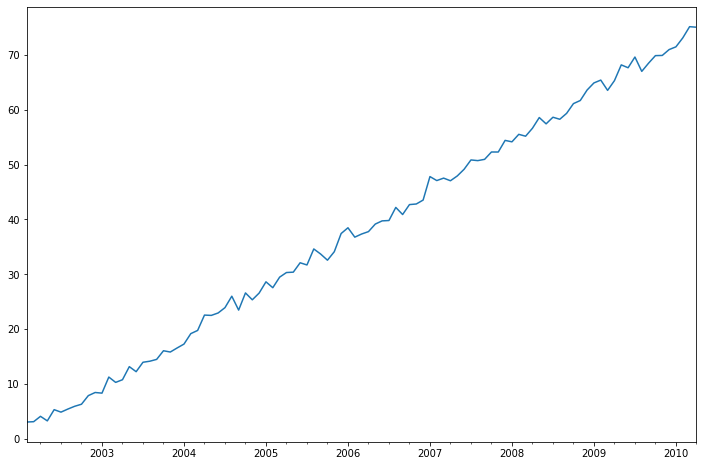

In [109]:
dfx['x'].plot(figsize=(12,8))

## Paso 2: test ADF

In [112]:
adf_test(dfx['x'],'ct')

Results of Dickey-Fuller Test:
Test Statistic                -8.567492e+00
p-value                        3.511156e-12
#Lags Used                     0.000000e+00
Number of Observations Used    9.800000e+01
Critical Value (1%)           -4.054251e+00
Critical Value (5%)           -3.456279e+00
Critical Value (10%)          -3.153866e+00
dtype: float64


# Ejemplo Pib Ecuador

In [189]:
# Importar la data

df = pd.read_csv(r'CTASTRIM110.csv',header=0)
df['t']=df.index.values
df.index = pd.period_range('2000Q1', '2019Q4', freq='Q')

In [190]:
# Generar algunas variables

df['y']=np.log(df['pib'])
df['ly']=df['y'].shift()
df['dy']=df['y'].diff()
df['dly']=df['dy'].shift()
df=df[2:]

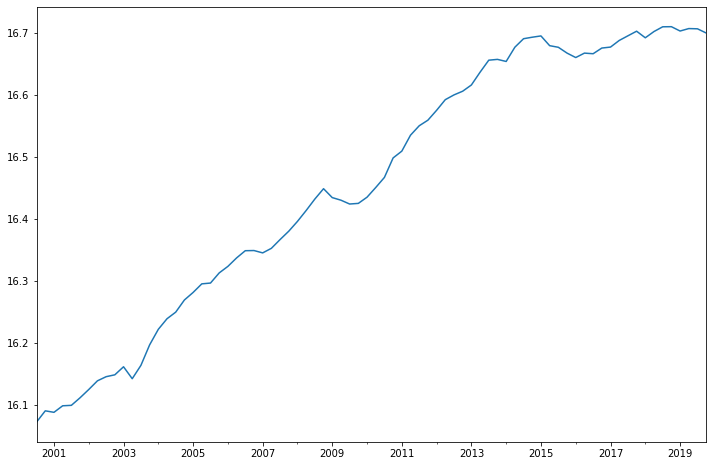

In [191]:
# Graficar la serie

df['y'].plot(figsize=(12,8))

In [192]:
# Testear ADF con constante y tendencia

adf_test(df['y'],'ct')

Results of Dickey-Fuller Test:
Test Statistic                 -0.150191
p-value                         0.992349
#Lags Used                      1.000000
Number of Observations Used    76.000000
Critical Value (1%)            -4.083117
Critical Value (5%)            -3.469926
Critical Value (10%)           -3.161802
dtype: float64


In [193]:
df.loc[:,::-1]

,dly,dy,ly,y,t,pib,servicios financieros,construccion,electricidad y agua,manufactura,refinacion petroleo,petroleo y minas,pesca,acuicultura y camaron,agricultura,datetime,quarter,year
2000Q3,0.020139,0.024176,16.047718,16.071894,2,9548491,199255,584021,127071,1163347,305580,964910,67215,16938,795921,2000q3,3,2000
2000Q4,0.024176,0.018103,16.071894,16.089996,3,9722918,205530,606306,130164,1175038,301765,969273,69094,17338,806318,2000q4,4,2000
2001Q1,0.018103,-0.002426,16.089996,16.087571,4,9699363,173319,646343,125913,1194620,273045,1009422,69754,20274,831433,2001q1,1,2001
2001Q2,-0.002426,0.010568,16.087571,16.098139,5,9802413,181735,679647,126847,1205261,272351,987165,70063,21160,832327,2001q2,2,2001
2001Q3,0.010568,0.000721,16.098139,16.098860,6,9809483,185457,719479,129345,1208396,252792,981463,69372,21932,853085,2001q3,3,2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018Q4,0.007641,0.000172,16.710363,16.710534,75,18083933,623886,1501173,498388,2095890,156829,1581110,113114,210752,1369397,2018q4,4,2018
2019Q1,0.000172,-0.007003,16.710534,16.703531,76,17957733,621668,1476298,545837,2109667,139184,1582616,117164,222482,1394325,2019q1,1,2019
2019Q2,-0.007003,0.003960,16.703531,16.707491,77,18028980,632152,1469861,568869,2132482,125218,1602148,120455,230124,1388267,2019q2,2,2019
2019Q3,0.003960,-0.000385,16.707491,16.707106,78,18022042,633668,1477438,543705,2141289,132795,1640124,123511,229922,1369858,2019q3,3,2019


In [194]:
# Estimar la ecuacion

X = [df['t'],df['ly'],df['dly']]
X= np.column_stack(X)
X=sm.add_constant(X)

model = sm.OLS(df['dy'],X)
results = model.fit()

print(results.summary(xname=['const','t','ly','dly']))

                            OLS Regression Results                            
Dep. Variable:                     dy   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     5.793
Date:                Thu, 02 Jul 2020   Prob (F-statistic):            0.00130
Time:                        14:37:35   Log-Likelihood:                 252.29
No. Observations:                  78   AIC:                            -496.6
Df Residuals:                      74   BIC:                            -487.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1411      0.454      0.310      0.7

In [195]:
print(results.f_test('x1=x2=0'))

<F test: F=array([[2.22689505]]), p=0.11504248445077403, df_denom=74, df_num=2>


In [196]:
# Testear ADF sin tendencia

adf_test(df['y'],'c')

Results of Dickey-Fuller Test:
Test Statistic                 -1.863591
p-value                         0.349378
#Lags Used                      1.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64


In [197]:
#Estimar la ecuacion

X = [df['ly'],df['dly']]
X= np.column_stack(X)
X=sm.add_constant(X)

model = sm.OLS(df['dy'],X)
results = model.fit()

print(results.summary(xname=['const','ly','dly']))

                            OLS Regression Results                            
Dep. Variable:                     dy   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     8.798
Date:                Thu, 02 Jul 2020   Prob (F-statistic):           0.000369
Time:                        15:13:36   Log-Likelihood:                 252.28
No. Observations:                  78   AIC:                            -498.6
Df Residuals:                      75   BIC:                            -491.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1923      0.088      2.178      0.0

In [198]:
print(results.f_test('const=x1=0'))

<F test: F=array([[8.55385236]]), p=0.0004505042316172856, df_denom=75, df_num=2>


# Tablas

<img src="fig6.png" align="left"  width="300" height="250" > <img src="fig7.png" align="right" width="300" height="250">

# Referencias

[Enders, W (2015)](https://www.amazon.com/Applied-Econometric-Wiley-Probability-Statistics/dp/1118808568/ref=sr_1_1?dchild=1&keywords=applied+time+series+econometrics&qid=1590717656&sr=8-1)